<a href="https://colab.research.google.com/github/zzh8829/yolov3-tf2/blob/master/colab_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YoloV3 TF2 GPU Colab Notebook

#####  Clone and install dependencies 

**IMPORTANT**: Restart following the instruction

In [ ]:
#!git clone https://github.com/chrivasileiou/yolov3-tf2

# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd 'drive/My Drive/Colab Notebooks/build_tf_v3/yolov3-tf2/'

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/build_tf_v3/yolov3-tf2


In [ ]:
#%load_ext tensorboard
#!pip install -U tensorboard_plugin_profile
!pip install -r requirements-gpu.txt
#!pip install -q tensorflow-model-analysis==0.21.3
#!pip install --upgrade tensorflow
#!pip install tf-nightly
#!pip install tensorflow-model-optimization
#!pip install tensorflow==2.1
#!pip install tensorflow==2.2

Obtaining file:///content/drive/My%20Drive/Colab%20Notebooks/build_tf_v3/yolov3-tf2 (from -r requirements-gpu.txt (line 5))
  Found existing installation: yolov3-tf2 1.0
    Can't uninstall 'yolov3-tf2'. No files were found to uninstall.
  Running setup.py develop for yolov3-tf2


##### Check Tensorflow2 version

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print(tf.__version__)
#print("python: ", sys.version)
#print("Show System RAM Memory:\n")
#!cat /proc/meminfo | egrep "MemTotal*"
print("\nShow Devices:\n", str(device_lib.list_local_devices()))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.1.0

Show Devices:
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6394898677471512392
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17115861680090164426
physical_device_desc: "device: XLA_CPU device"
]
Num GPUs Available:  0


### 1.   COCO (80-classes) and VOC (20-classes) DATASETs

##### 1.1.   Convert Pretrained Darknet Weight

In [ ]:
#!wget https://pjreddie.com/media/files/yolov3-tiny.weights -O data/yolov3-tiny.weights
!python convert.py \
  --tiny=True \
  --weights='./data/yolov3-tiny.weights' \
  --mixed_precision='float32' \
  --output='./checkpoints_tiny/yolov3-tiny.tf'

2020-06-02 14:09:31.192382: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-06-02 14:09:32.928248: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-02 14:09:32.932873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-06-02 14:09:32.933307: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-06-02 14:09:32.933340: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-06-02 14:09:32.934810: I tensorflow/stream_executor/platform/default

##### 1.2.   Initialize Detector

In [ ]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
import yolov3_tf2.models as models
import yolov3_tf2.dataset as dateset
import yolov3_tf2.utils as utils
from IPython.display import Image, display

flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3_coco.tf',
                    'path to weights file')
flags.DEFINE_string('pretrained_mixed_precision', 'float32', 'pretrained weights are quantized or not. if not, they will be transformed considering the value of `quantized` ')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.jpg', 'path to input image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')
flags.DEFINE_enum('split', 'train', ['train', 'val'], 'specify train or val split')

app._run_init(['yolov3'], app.parse_flags_with_usage)

#physical_devices = tf.config.experimental.list_physical_devices('TPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

['yolov3']

##### 1.3.   Detect COCO-Image

I0616 12:12:26.965142 140490451924864 <ipython-input-11-a5584996beba>:15] weights loaded


Model: "yolov3_tiny"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
input (InputLayer)                                                [(None, 416, 416, 3)]                       0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
yolo_darknet (Model)                                              ((None, 26, 26, 256), (None, 13, 13, 1024)) 6298480                 input[0][0]                              

I0616 12:12:27.418725 140490451924864 utils.py:189] classes loaded
I0616 12:12:27.683227 140490451924864 utils.py:202] time: 0.22251129150390625
I0616 12:12:27.684103 140490451924864 utils.py:204] detections:
I0616 12:12:27.686331 140490451924864 utils.py:208] 	car, 0.9157130122184753, [0.29056033 0.32918245 0.36899236 0.57195526]
I0616 12:12:27.690746 140490451924864 utils.py:208] 	bus, 0.90668785572052, [0.38724512 0.20496956 0.60455734 0.4477726 ]
I0616 12:12:27.693407 140490451924864 utils.py:208] 	bus, 0.674160361289978, [0.69910836 0.24571696 0.9509245  0.4886879 ]
I0616 12:12:27.695782 140490451924864 utils.py:208] 	person, 0.5871637463569641, [0.22486968 0.3604838  0.28896457 0.5308856 ]
I0616 12:12:27.705323 140490451924864 utils.py:221] Interactive Python is active: <function get_ipython at 0x7fc67927e8c8>


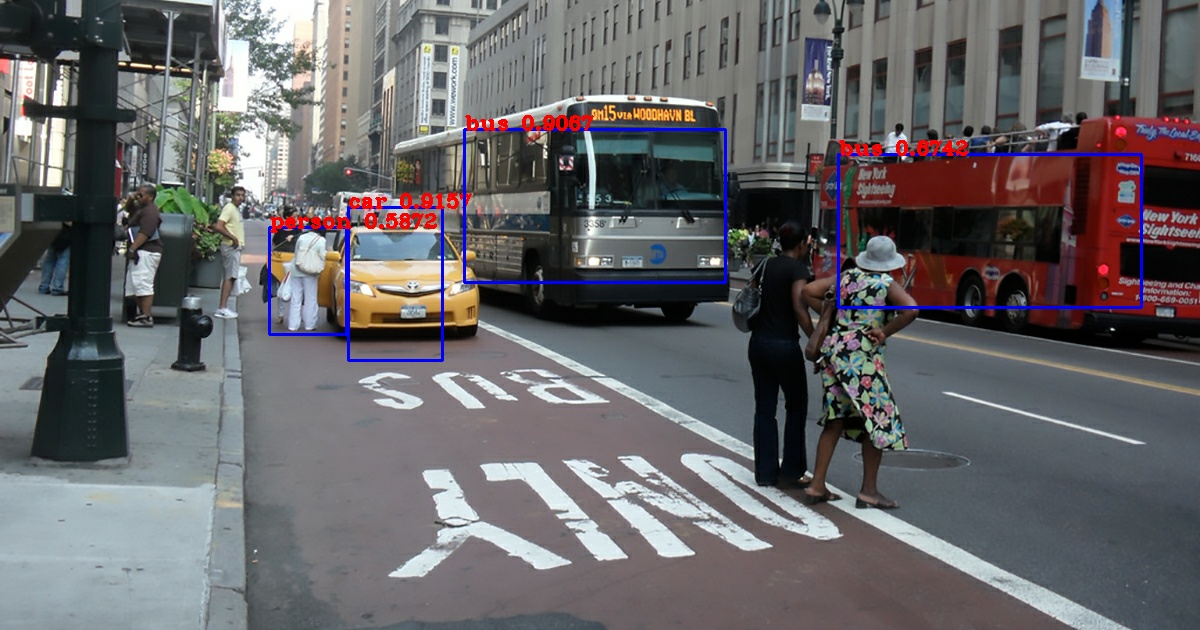

I0616 12:12:27.770629 140490451924864 utils.py:225] 
`output.jpg` extracted and it has shown up!


In [ ]:
FLAGS.image = 'data/street.jpg'
FLAGS.weights = 'checkpoints_tiny/yolov3-tiny.tf'
FLAGS.edge_tpu = False
FLAGS.num_classes = 80
FLAGS.classes = './data/coco.names'
FLAGS.pretrained_mixed_precision='float32'
FLAGS.tiny = True

#resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER)
if FLAGS.tiny:
  yolo = models.YoloV3Tiny(size=FLAGS.size, classes=FLAGS.num_classes, \
                  mixed_precision=FLAGS.pretrained_mixed_precision)
else:
  yolo = models.YoloV3(size=FLAGS.size, classes=FLAGS.num_classes, \
                  mixed_precision=FLAGS.pretrained_mixed_precision)    
yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

utils.print_all_layers(yolo)

utils.Inference(yolo, FLAGS.classes, FLAGS.image, size=FLAGS.size, scale=1)


##### 1.4.   Download VOC-Dataset

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar -O ./data/voc2012_raw.tar 
!tar -xf ./data/voc2012_raw.tar -C data/voc2012_raw


/content/drive/My Drive/Colab Notebooks/build_tf_v3/yolov3-tf2
tar: data/VOCtrainval_11May2012.tar: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
!python tools/voc2012.py \
  --data_dir 'data/voc2012_raw/VOCdevkit/VOC2012' \
  --split train \
  --output_file ./data/voc_train.tfrecord

  !python tools/voc2012.py \
  --data_dir 'data/voc2012_raw/VOCdevkit/VOC2012' \
  --split val \
  --output_file ./data/voc_val.tfrecord

2020-04-22 11:30:56.866369: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
I0422 11:30:58.482033 139896126207872 voc2012.py:98] Class mapping loaded: {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
I0422 11:31:02.064357 139896126207872 voc2012.py:107] Image list loaded: 17151
100% 17151/17151 [1:05:20<00:00,  4.37it/s] 
I0422 12:36:22.902779 139896126207872 voc2012.py:117] Done
2020-04-22 12:36:27.318631: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
I0422 12:36:28.825758 140235842107264 voc2012.py:98] Class mapping loaded: {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, '

In [ ]:
!python tools/visualize_dataset.py --dataset ./data/voc_train.tfrecord --classes=./data/voc2012.names
from IPython.display import Image
Image(filename='./output.jpg')

##### 1.5. Export Yolo(9) or YoloV3Tiny(6) Anchors

In [ ]:
!python3 ./tools/export_anchors_kmeans.py \
  --tiny=True \
  --data_dir='./data/voc2012_raw/VOCdevkit/VOC2012/' \
  --classes='./data/voc2012.names' \
  --output='./data/anchors_tiny.txt'

2020-06-08 11:21:39.828460: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-08 11:21:39.828647: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-08 11:21:39.828672: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
dataset: 
	./data/voc2012_raw/VOCdevkit/VOC2012/ 


I0608 11:21:42.036181 140496003274624 export_anchors_kmeans.py:26] 20 classes read!
100% 17125/17125 [2:58:00<00:00,  1.60it/s]
(40138, 2)
(40138, 1)
cluster

##### 1.5.   Training VOC-Dataset

In [ ]:
!python train.py \
  --size=416 \
	--tiny=True \
	--dataset ./data/voc_train.tfrecord \
	--val_dataset ./data/voc_val.tfrecord \
	--classes ./data/voc2012.names \
	--num_classes 20 \
	--mixed_precision='float32' \
	--pretrained_mixed_precision='float32' \
	--pretrained_weights_num_classes 80 \
	--weights ./checkpoints_tiny/yolov3-tiny-voc.tf \
	--output_weights ./checkpoints_tiny/yolov3-tiny-voc-metrics-relu.tf \
	--pdetails=True \
	--mode 'eager_fit' \
	--transfer 'all' \
	--batch_size=32 \
	--learning_rate=1e-3 \
	--epochs=10 \
	--accelerator='GPU' \
	--anchorstxt=./data/anchors_tiny.txt \
	--metrics=True \
	--log_output_fit='logs/tiny-voc-relu-metrics' \
	--edge_tpu=True


2020-06-12 13:23:39.430841: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-12 13:23:39.431017: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-12 13:23:39.431044: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2020-06-12 13:23:43.289137: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-12 13:23:43.341104: I tensorflow/stream_executor/cuda/cuda_g

##### 1.6. Analyzing using Tensorboard

In [ ]:
%tensorboard --logdir=logs/voc-tiny

#!kill 6690 

##### 1.7.   Detect VOC-Image

In [ ]:
FLAGS.num_classes = 20
FLAGS.classes = './data/voc2012.names'
FLAGS.weights = './checkpoints_tiny/yolov3-tiny-voc.tf'
FLAGS.image = './data/street.jpg'
FLAGS.edge_tpu = False
FLAGS.tiny = True
FLAGS.size = 416
FLAGS.pretrained_mixed_precision = 'float32'

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.5
FLAGS.yolo_score_threshold = 0.5

if FLAGS.tiny:
  yolo = models.YoloV3Tiny(size=FLAGS.size, classes=FLAGS.num_classes, \
                  mixed_precision=FLAGS.pretrained_mixed_precision, batch_size=None)
else:
  yolo = models.YoloV3(size=FLAGS.size, classes=FLAGS.num_classes, \
                  mixed_precision=FLAGS.pretrained_mixed_precision, batch_size=None)
yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

utils.print_all_layers(yolo)

utils.Inference(yolo, FLAGS.classes, FLAGS.image, size=FLAGS.size, scale=1)


NameError: ignored

2020-06-16 12:11:36.747620: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-06-16 12:11:36.747773: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-06-16 12:11:36.747798: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0616 12:11:37.933617 140172329289600 utils.py:252] CPU is running...
2020-06-16 12:11:37.949409: I tensorflow/stream_executor/platform/default/dso_loade

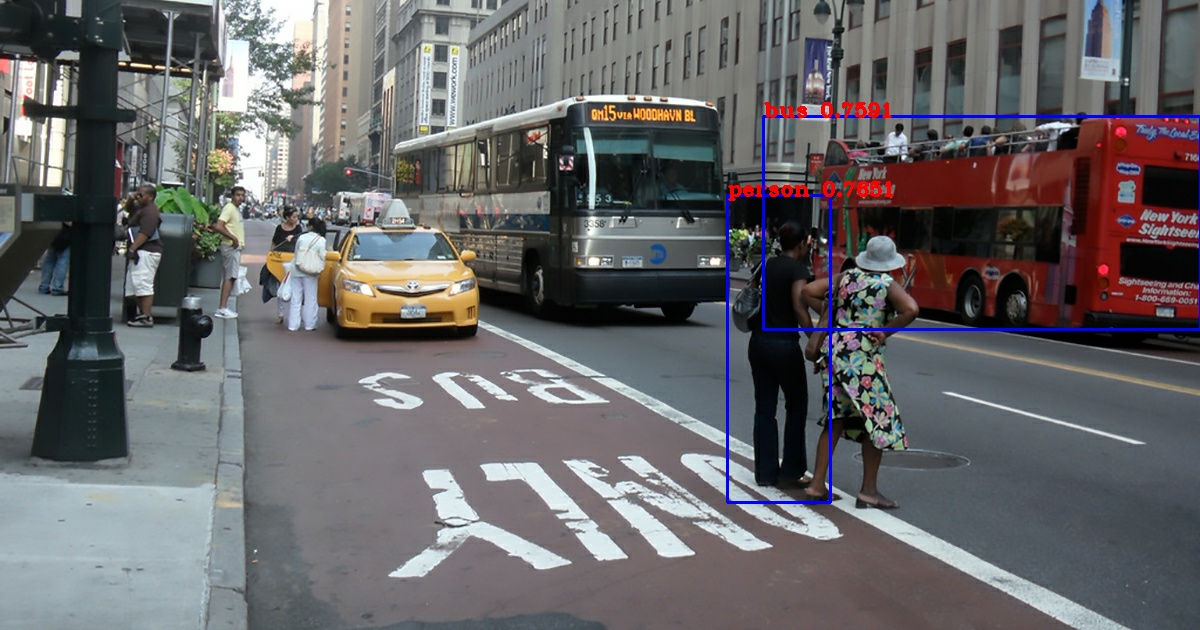

In [ ]:
!python3 detect.py \
  --tiny=True \
  --weights=./checkpoints_tiny/yolov3-tiny-voc.tf \
  --classes=./data/voc2012.names \
  --num_classes=20 \
  --image=./data/street.jpg \
  --accelerator='gpu'
from IPython.display import Image
Image(filename='./output.jpg')

##### 1.8.   Export Serving and Graph 

In [ ]:
!python export_tfserving_graph.py \
  --size=416 \
  --tiny=True \
  --weights './checkpoints_tiny/yolov3-tiny-voc.tf' \
  --classes './data/voc2012.names' \
  --image './data/street.jpg' \
  --num_classes=20 \
  --batch_size=1 \
  --training=True \
  --edge_tpu=True \
  --output './tiny-voc-relu.h5' 

2020-06-09 08:25:20.670948: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-09 08:25:20.671088: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-06-09 08:25:20.671116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2020-06-09 08:25:21.998562: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-09 08:25:22.002083: I tensorflow/stream_executor/cuda/cuda_g

##### 1.9.   Export tflite model

In [ ]:
!mv ./tiny-voc-relu.h5 ./serving/yolov3/
!ls -lh ./serving/yolov3/


total 481M
drwx------ 4 root root 4.0K May 30 09:57 firedetect_relu
drwx------ 4 root root 4.0K Jun  8 21:24 tiny-voc-relu
-rw------- 1 root root  52M Jun  9 08:25 tiny-voc-relu.h5
drwx------ 4 root root 4.0K May 20 13:26 voc
drwx------ 4 root root 4.0K Jun  3 23:00 yolo_320
-rw------- 1 root root 396M Jun  5 14:54 yolo_416.h5
drwx------ 4 root root 4.0K Jun  4 13:32 yolo_tiny_416
-rw------- 1 root root  34M Jun  5 13:48 yolo_tiny_416.h5


In [ ]:
import time
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import pathlib
import numpy as np
import tensorflow as tf
import yolov3_tf2.models as models
import yolov3_tf2.dataset as dataset 
import yolov3_tf2.utils as utils
from IPython.display import Image, display

flags.DEFINE_string('weights', './serving/yolov3/yolo_tiny_416.h5',
                    'path to weights file')
flags.DEFINE_string('output', 'yolov3_firedetect.tflite',
                    'path to saved_model')
flags.DEFINE_integer('size', 416, 'image size')

app._run_init(['yolov3'], app.parse_flags_with_usage)


['yolov3']

In [ ]:
FLAGS.weights = './serving/yolov3/yolo_tiny_416.h5'
FLAGS.output = 'quant_yolov3_tiny_voc_relu_edgetpu.tflite'

def representative_dataset_gen():
  # 17,126 images in this directory
  dataset_list = tf.data.Dataset.list_files('./data/voc2012_raw/VOCdevkit/VOC2012/JPEGImages/*')
  for i, image in enumerate(dataset_list):
    if i > 250:
      break
    print(i, image)
    image = tf.io.read_file(image)
    image = tf.io.decode_image(image, channels=3)
    image = dataset.transform_images(image, FLAGS.size)
    image = tf.expand_dims(image, 0)
    yield [image]

# Create the converter using keras model file
converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file(model_file=FLAGS.weights)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# EdgeTpu's builtin Ops are int8
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS]
#converter.target_spec.supported_types = [tf.int8]
converter.inference_type = tf.compat.v1.lite.constants.QUANTIZED_UINT8
input_arrays = converter.get_input_arrays()
print("\n", input_arrays, "\n")
converter.quantized_input_stats = {input_arrays[0] : (0., 1.)}

# set Inputs and Outputs of network to 8-bit signed integer
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_yolo = converter.convert()
logging.info('converted')

# write model to file
tflite_yolo_dir = pathlib.Path('./checkpoints_lite/')
tflite_yolo_dir.mkdir(exist_ok=True, parents=True)
tflite_yolo_file = tflite_yolo_dir/FLAGS.output
tflite_yolo_file.write_bytes(tflite_yolo)
logging.info('Exported `{}` file in directory `./checkpoints_lite/` \n\n'.format(FLAGS.output))

W0618 12:12:06.525312 140619091273600 training_utils.py:1444] Output yolo_output_0 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to yolo_output_0.


W0618 12:12:06.527940 140619091273600 training_utils.py:1444] Output yolo_output_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to yolo_output_1.



 ['input'] 



ValueError: ignored

In [ ]:
!python export_tflite.py \
  --weights='./checkpoints/yolov3.tf' \
  --quantized_weights=False \
  --tf_saved_format=True \
  --output='./checkpoints_lite/yolov3_OSIZE_ncT_nquT_FLOAT16.tflite' \
  --classes='./my_data/classes.names' \
  --image='./my_data/resized_images_43.jpg' \
  --num_classes=4



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

W0421 09:13:13.742333 139788366567296 base_layer.py:2081] Layer yolo_darknet_0_BN is casting an input tensor from dtype float16 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by d

### 2.   TPU usage

#####   2.1. Testing tpu's initialization.

In [ ]:
import tensorflow as tf
import os

print(os.environ)
if 'COLAB_TPU_ADDR' in os.environ:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://'+os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
else:
  print("--- TPU is NOT connected!")



environ({'COLAB_TPU_ADDR': '10.122.26.90:8470', 'GCS_READ_CACHE_BLOCK_SIZE_MB': '16', 'CLOUDSDK_CONFIG': '/content/.config', 'CUDA_VERSION': '10.1.243', 'PATH': '/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin', 'HOME': '/root', 'LD_LIBRARY_PATH': '/usr/local/nvidia/lib:/usr/local/nvidia/lib64', 'LANG': 'en_US.UTF-8', 'SHELL': '/bin/bash', 'LIBRARY_PATH': '/usr/local/cuda/lib64/stubs', 'CUDA_PKG_VERSION': '10-1=10.1.243-1', 'SHLVL': '1', 'GCE_METADATA_TIMEOUT': '0', 'NCCL_VERSION': '2.4.8', 'NVIDIA_VISIBLE_DEVICES': 'all', 'TF_FORCE_GPU_ALLOW_GROWTH': 'true', 'DEBIAN_FRONTEND': 'noninteractive', 'CUDNN_VERSION': '7.6.5.32', 'LAST_FORCED_REBUILD': '20200316', 'JPY_PARENT_PID': '22', 'PYTHONPATH': '/env/python', 'DATALAB_SETTINGS_OVERRIDES': '{"kernelManagerProxyPort":6000,"kernelManagerProxyHost":"172.28.0.3","jupyterArgs":["--ip=\\"172.28.0.2\\""]}', 'ENV': '/root/.bashrc', 'GLIB

INFO:tensorflow:Initializing the TPU system: grpc://10.122.26.90:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


#####   2.2. Initialize Detector

In [ ]:
from absl import app, logging, flags
from absl.flags import FLAGS
from IPython.display import Image, display
from tensorflow.keras.callbacks import (TensorBoard, ModelCheckpoint)
import time
import cv2
import os
import numpy as np
import tensorflow as tf
import yolov3_tf2.models as models
import yolov3_tf2.dataset as dataset
import yolov3_tf2.utils as utils

flags.DEFINE_string('classes', './my_data/classes.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3_firedetect.tf',
                    'path to weights file')
flags.DEFINE_string('mixed_precision', 'float32', 'pretrained weights are quantized or not. if not, they will be transformed considering the value of `quantized` ')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './my_data/resized_images_43.jpg', 'path to input image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 4, 'number of classes in the model')
flags.DEFINE_float('learning_rate', 1e-3, 'learning rate')

app._run_init(['yolov3'], app.parse_flags_with_usage)



['yolov3']

#####   2.3. Create and Train the model.

In [ ]:
anchors = np.array([(30, 25), (43, 60), (51, 101), (98, 69), 
                                (63, 147), (121, 131), (99, 208), (173, 250), (306, 176)],
                                 np.float32) / 416
                                 
anchor_masks = [[6,7,8], [3,4,5], [0,1,2]]

print(os.environ)
if 'COLAB_TPU_ADDR' in os.environ:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://'+os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
elif 'COLAB_GPU' in os.environ:
  physical_devices = tf.config.experimental.list_physical_devices('GPU')
  for physical_device in physical_devices:
      if not tf.config.experimental.get_memory_growth(physical_device):
          tf.config.experimental.set_memory_growth(physical_device, True)
  tf.config.set_visible_devices(physical_devices, 'GPU')
  logical_devices = tf.config.list_logical_devices('GPU')
  assert len(logical_devices) == len(physical_devices)
  logging.info("Synchronous Execution: \n{}".format(tf.config.experimental.get_synchronous_execution()))
  logging.info('--- GPU is ready! ---')
else:
  print("--- Accelerator is NOT connected! ---")

train_dataset = dataset.load_tfrecord_dataset('./my_data/final_fire_smoke_train.tfrecord', FLAGS.classes, FLAGS.size)
train_dataset = train_dataset.shuffle(buffer_size=256, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(8)
train_dataset = train_dataset.map(lambda x, y: (
    dataset.transform_images(x, FLAGS.size),
    dataset.transform_targets(y, anchors, anchor_masks, FLAGS.size)
))
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = dataset.load_tfrecord_dataset('./my_data/final_fire_smoke_val.tfrecord', FLAGS.classes, FLAGS.size)
val_dataset = val_dataset.batch(8)
val_dataset = val_dataset.map(lambda x, y: (
    dataset.transform_images(x, FLAGS.size),
    dataset.transform_targets(y, anchors, anchor_masks, FLAGS.size)
))

environ({'NO_GCE_CHECK': 'True', 'GCS_READ_CACHE_BLOCK_SIZE_MB': '16', 'CLOUDSDK_CONFIG': '/content/.config', '__EGL_VENDOR_LIBRARY_DIRS': '/usr/lib64-nvidia:/usr/share/glvnd/egl_vendor.d/', 'CUDA_VERSION': '10.1.243', 'PATH': '/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin', 'HOME': '/root', 'LD_LIBRARY_PATH': '/usr/lib64-nvidia', 'LANG': 'en_US.UTF-8', 'SHELL': '/bin/bash', 'LIBRARY_PATH': '/usr/local/cuda/lib64/stubs', 'CUDA_PKG_VERSION': '10-1=10.1.243-1', 'SHLVL': '1', 'GCE_METADATA_TIMEOUT': '0', 'NCCL_VERSION': '2.4.8', 'NVIDIA_VISIBLE_DEVICES': 'all', 'TF_FORCE_GPU_ALLOW_GROWTH': 'true', 'DEBIAN_FRONTEND': 'noninteractive', 'CUDNN_VERSION': '7.6.5.32', 'LAST_FORCED_REBUILD': '20200430', 'JPY_PARENT_PID': '25', 'PYTHONPATH': '/env/python', 'DATALAB_SETTINGS_OVERRIDES': '{"kernelManagerProxyPort":6000,"kernelManagerProxyHost":"172.28.0.3","jupyterArgs":["--ip=\\"172.28.0.2

I0507 16:51:57.237322 140238742087552 <ipython-input-3-cc24a763a654>:21] Synchronous Execution: 
True
I0507 16:51:57.240865 140238742087552 <ipython-input-3-cc24a763a654>:22] --- GPU is ready! ---


In [ ]:

FLAGS.weights='./checkpoints/yolov3_firedetect_3.tf'
#with strategy.scope():
yolo = models.YoloV3(size=FLAGS.size, classes=FLAGS.num_classes, 
                     training=True, mixed_precision=FLAGS.mixed_precision,
                     fire_anchors=True)
yolo.load_weights(FLAGS.weights)
anchors = models.adjust_yolo_anchors(anchors, FLAGS.size)
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
loss = [models.YoloLoss(anchors[mask], classes=FLAGS.num_classes)
        for mask in anchor_masks]
yolo.compile(optimizer=optimizer, loss=loss, metrics=[['accuracy'], ['accuracy'], ['accuracy']],
                      run_eagerly=True)
callbacks = [
              ModelCheckpoint('checkpoints/yolov3_deleteme', verbose=1, save_best_only=True),
              TensorBoard(log_dir='logs')
              ]
              
yolo.fit(train_dataset, epochs=20, callbacks=callbacks, validation_data=val_dataset, workers=2)
#utils.Inference(yolo, FLAGS.classes, FLAGS.image)
  

Epoch 1/20
     10/Unknown - 19s 2s/step - loss: 60.0380 - yolo_output_0_loss: 11.4504 - yolo_output_1_loss: 16.2699 - yolo_output_2_loss: 25.7712 - yolo_output_0_accuracy: 0.0553 - yolo_output_1_accuracy: 0.1432 - yolo_output_2_accuracy: 0.0984
Epoch 00001: val_loss improved from inf to 64142574867428933632.00000, saving model to checkpoints/yolov3_deleteme
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


W0507 17:01:45.003154 140238742087552 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: checkpoints/yolov3_deleteme/assets


I0507 17:01:57.837331 140238742087552 builder_impl.py:775] Assets written to: checkpoints/yolov3_deleteme/assets


10/10 [==============================] - 92s 9s/step - loss: 60.0380 - yolo_output_0_loss: 11.4504 - yolo_output_1_loss: 16.2699 - yolo_output_2_loss: 25.7712 - yolo_output_0_accuracy: 0.0553 - yolo_output_1_accuracy: 0.1432 - yolo_output_2_accuracy: 0.0984 - val_loss: 64142574867428933632.0000 - val_yolo_output_0_loss: 40971642745537953792.0000 - val_yolo_output_1_loss: 2406894724876075008.0000 - val_yolo_output_2_loss: 20764032998968393728.0000 - val_yolo_output_0_accuracy: 0.3328 - val_yolo_output_1_accuracy: 0.2932 - val_yolo_output_2_accuracy: 2.4655e-04
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 59.8235 - yolo_output_0_loss: 9.6176 - yolo_output_1_loss: 12.7102 - yolo_output_2_loss: 22.4889 - yolo_output_0_accuracy: 0.4094 - yolo_output_1_accuracy: 0.1438 - yolo_output_2_accuracy: 0.1264 
Epoch 00002: val_loss did not improve from 64142574867428933632.00000
10/10 [==============================] - 30s 3s/step - loss: 59.8235 - yolo_output_0_loss: 9.6176 -

I0507 17:05:09.944109 140238742087552 builder_impl.py:775] Assets written to: checkpoints/yolov3_deleteme/assets


10/10 [==============================] - 92s 9s/step - loss: 75.1637 - yolo_output_0_loss: 4.9030 - yolo_output_1_loss: 22.4029 - yolo_output_2_loss: 19.7602 - yolo_output_0_accuracy: 0.2967 - yolo_output_1_accuracy: 0.0265 - yolo_output_2_accuracy: 0.0186 - val_loss: 12985413743453143040.0000 - val_yolo_output_0_loss: 12418546230102065152.0000 - val_yolo_output_1_loss: 566204713997959168.0000 - val_yolo_output_2_loss: 661527371710464.0000 - val_yolo_output_0_accuracy: 0.5962 - val_yolo_output_1_accuracy: 0.0022 - val_yolo_output_2_accuracy: 0.0870
Epoch 6/20
10/10 [==============================] - ETA: 0s - loss: 62.6127 - yolo_output_0_loss: 4.9753 - yolo_output_1_loss: 10.9577 - yolo_output_2_loss: 18.9463 - yolo_output_0_accuracy: 0.3161 - yolo_output_1_accuracy: 0.0408 - yolo_output_2_accuracy: 0.0089
Epoch 00006: val_loss improved from 12985413743453143040.00000 to 3728602843578368.00000, saving model to checkpoints/yolov3_deleteme
INFO:tensorflow:Assets written to: checkpoints/

I0507 17:06:46.182048 140238742087552 builder_impl.py:775] Assets written to: checkpoints/yolov3_deleteme/assets


10/10 [==============================] - 93s 9s/step - loss: 62.6127 - yolo_output_0_loss: 4.9753 - yolo_output_1_loss: 10.9577 - yolo_output_2_loss: 18.9463 - yolo_output_0_accuracy: 0.3161 - yolo_output_1_accuracy: 0.0408 - yolo_output_2_accuracy: 0.0089 - val_loss: 3728602843578368.0000 - val_yolo_output_0_loss: 2670935471554560.0000 - val_yolo_output_1_loss: 1043125887827968.0000 - val_yolo_output_2_loss: 14541475807232.0000 - val_yolo_output_0_accuracy: 0.5833 - val_yolo_output_1_accuracy: 0.3249 - val_yolo_output_2_accuracy: 0.2704
Epoch 7/20
10/10 [==============================] - ETA: 0s - loss: 63.1450 - yolo_output_0_loss: 4.7822 - yolo_output_1_loss: 13.0792 - yolo_output_2_loss: 18.7518 - yolo_output_0_accuracy: 0.3209 - yolo_output_1_accuracy: 0.0371 - yolo_output_2_accuracy: 0.0134
Epoch 00007: val_loss improved from 3728602843578368.00000 to 2289443536896.00000, saving model to checkpoints/yolov3_deleteme
INFO:tensorflow:Assets written to: checkpoints/yolov3_deleteme/as

I0507 17:08:21.970731 140238742087552 builder_impl.py:775] Assets written to: checkpoints/yolov3_deleteme/assets


10/10 [==============================] - 92s 9s/step - loss: 63.1450 - yolo_output_0_loss: 4.7822 - yolo_output_1_loss: 13.0792 - yolo_output_2_loss: 18.7518 - yolo_output_0_accuracy: 0.3209 - yolo_output_1_accuracy: 0.0371 - yolo_output_2_accuracy: 0.0134 - val_loss: 2289443536896.0000 - val_yolo_output_0_loss: 1780376535040.0000 - val_yolo_output_1_loss: 495895183360.0000 - val_yolo_output_2_loss: 13171877888.0000 - val_yolo_output_0_accuracy: 0.5242 - val_yolo_output_1_accuracy: 0.3108 - val_yolo_output_2_accuracy: 0.3153
Epoch 8/20
10/10 [==============================] - ETA: 0s - loss: 64.9282 - yolo_output_0_loss: 6.8590 - yolo_output_1_loss: 13.2969 - yolo_output_2_loss: 19.6601 - yolo_output_0_accuracy: 0.3248 - yolo_output_1_accuracy: 0.0238 - yolo_output_2_accuracy: 0.0568
Epoch 00008: val_loss improved from 2289443536896.00000 to 1764590616576.00000, saving model to checkpoints/yolov3_deleteme
INFO:tensorflow:Assets written to: checkpoints/yolov3_deleteme/assets


I0507 17:09:58.438410 140238742087552 builder_impl.py:775] Assets written to: checkpoints/yolov3_deleteme/assets


10/10 [==============================] - 93s 9s/step - loss: 64.9282 - yolo_output_0_loss: 6.8590 - yolo_output_1_loss: 13.2969 - yolo_output_2_loss: 19.6601 - yolo_output_0_accuracy: 0.3248 - yolo_output_1_accuracy: 0.0238 - yolo_output_2_accuracy: 0.0568 - val_loss: 1764590616576.0000 - val_yolo_output_0_loss: 1344636190720.0000 - val_yolo_output_1_loss: 417347928064.0000 - val_yolo_output_2_loss: 2606392064.0000 - val_yolo_output_0_accuracy: 0.3712 - val_yolo_output_1_accuracy: 0.3274 - val_yolo_output_2_accuracy: 0.0352
Epoch 9/20
10/10 [==============================] - ETA: 0s - loss: 59.1927 - yolo_output_0_loss: 4.4456 - yolo_output_1_loss: 11.4469 - yolo_output_2_loss: 19.3605 - yolo_output_0_accuracy: 0.3022 - yolo_output_1_accuracy: 0.0197 - yolo_output_2_accuracy: 0.0104
Epoch 00009: val_loss improved from 1764590616576.00000 to 466969624576.00000, saving model to checkpoints/yolov3_deleteme
INFO:tensorflow:Assets written to: checkpoints/yolov3_deleteme/assets


I0507 17:11:35.573584 140238742087552 builder_impl.py:775] Assets written to: checkpoints/yolov3_deleteme/assets


10/10 [==============================] - 94s 9s/step - loss: 59.1927 - yolo_output_0_loss: 4.4456 - yolo_output_1_loss: 11.4469 - yolo_output_2_loss: 19.3605 - yolo_output_0_accuracy: 0.3022 - yolo_output_1_accuracy: 0.0197 - yolo_output_2_accuracy: 0.0104 - val_loss: 466969624576.0000 - val_yolo_output_0_loss: 432227942400.0000 - val_yolo_output_1_loss: 34504835072.0000 - val_yolo_output_2_loss: 236901536.0000 - val_yolo_output_0_accuracy: 0.3402 - val_yolo_output_1_accuracy: 0.3230 - val_yolo_output_2_accuracy: 4.9618e-04
Epoch 10/20
10/10 [==============================] - ETA: 0s - loss: 57.1412 - yolo_output_0_loss: 4.3440 - yolo_output_1_loss: 11.1625 - yolo_output_2_loss: 18.8532 - yolo_output_0_accuracy: 0.2369 - yolo_output_1_accuracy: 0.0137 - yolo_output_2_accuracy: 0.0143
Epoch 00010: val_loss improved from 466969624576.00000 to 28058660864.00000, saving model to checkpoints/yolov3_deleteme
INFO:tensorflow:Assets written to: checkpoints/yolov3_deleteme/assets


I0507 17:13:13.663660 140238742087552 builder_impl.py:775] Assets written to: checkpoints/yolov3_deleteme/assets


10/10 [==============================] - 95s 9s/step - loss: 57.1412 - yolo_output_0_loss: 4.3440 - yolo_output_1_loss: 11.1625 - yolo_output_2_loss: 18.8532 - yolo_output_0_accuracy: 0.2369 - yolo_output_1_accuracy: 0.0137 - yolo_output_2_accuracy: 0.0143 - val_loss: 28058660864.0000 - val_yolo_output_0_loss: 26805360640.0000 - val_yolo_output_1_loss: 1242846464.0000 - val_yolo_output_2_loss: 10451875.0000 - val_yolo_output_0_accuracy: 0.3376 - val_yolo_output_1_accuracy: 0.3194 - val_yolo_output_2_accuracy: 0.1756
Epoch 11/20
 9/10 [==========================>...] - ETA: 1s - loss: 55.9378 - yolo_output_0_loss: 4.3927 - yolo_output_1_loss: 10.7169 - yolo_output_2_loss: 19.1529 - yolo_output_0_accuracy: 0.0617 - yolo_output_1_accuracy: 0.0241 - yolo_output_2_accuracy: 0.0866

KeyboardInterrupt: ignored

### EdgeTpu

##### 3.1 Finally, we're ready to compile the model for the Edge TPU.

First download the [Edge TPU Compiler](https://coral.ai/docs/edgetpu/compiler/):

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
! sudo apt-get update
! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  12557      0 --:--:-- --:--:-- --:--:-- 12557
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,332 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:8 https

##### Then, compile the model

In [ ]:
! edgetpu_compiler --help
! edgetpu_compiler checkpoints_lite/yolov3_tiny_firedetect_relu_edgetpu.tflite \
  --min_runtime_version 13 \
  --num_segments 1 \
  --out_dir ./edgetpu/

Edge TPU Compiler version 2.1.302470888

Usage:
edgetpu_compiler [options] model...

Options:
-o, --out_dir <dir>
       Output the compiled model and log files to directory <dir>.
       Default is the current directory (.)
-m, --min_runtime_version <val>
       Minimum Edge TPU runtime version required by your model.
       Models are forward-compatible with new Edge TPU runtimes.
       Default: 12; Min: 10; Max: 13
-i, --intermediate_tensors <str>
        A comma-separated list of tensors you want as outputs from
        the compiled model. All operators following these tensors
       will not be compiled for the Edge TPU. If you have multiple
       input models (for co-compilation), then separate the list of
       tensors for each model with a colon, and pass them in the
       order corresponding to the input models.
-n, --num_segments <val>
       Partition the model into [num_segments] segments.
       Default value is 1 (no partition).
-s, --show_operations
       Print the 

In [ ]:
!cat ./edgetpu/yolov3_tiny_firedetect_relu_edgetpu_edgetpu.log

Edge TPU Compiler version 2.1.302470888
Input: checkpoints_lite/yolov3_tiny_firedetect_relu_edgetpu.tflite
Output: ./edgetpu/yolov3_tiny_firedetect_relu_edgetpu_edgetpu.tflite

Operator                       Count      Status

QUANTIZE                       2          Mapped to Edge TPU
QUANTIZE                       2          Operation is otherwise supported, but not mapped due to some unspecified limitation
CONCATENATION                  1          Mapped to Edge TPU
CONV_2D                        13         Mapped to Edge TPU
RESHAPE                        2          Tensor has unsupported rank (up to 3 innermost dimensions mapped)
MAX_POOL_2D                    6          Mapped to Edge TPU
RESIZE_NEAREST_NEIGHBOR        1          Mapped to Edge TPU


# Informal

In [ ]:
import tensorflow as  tf
import time

iou = tf.convert_to_tensor([[[23,  454, 345], [4, 5, 43], [312, 1, 432], [1,2,3]], 
                            [[234, 3645, 3],[9, 2, 4],[435, 7, 4],[10, 4, 34]]])
iou2 = tf.cast(iou<10, tf.float32)


@tf.function()
def measure_flatten(p=False):
  flatten = tf.reshape(iou2, shape=(-1, tf.shape(iou2)[-1]))
  count= tf.cast(0, tf.int64)
  true = tf.cast(0, tf.int64)
  false = tf.cast(0, tf.int64)
  for f in flatten:
    if p:
      tf.print(f)
      ones = tf.math.count_nonzero(f)
      zeros = len(f)-ones
      if tf.math.logical_and(tf.math.greater(zeros, 0), True):
        false += ones
        true += zeros
        tf.print(count) 
  return true, false
    #tf.print(tf.math.count_nonzero(j))

@tf.function()
def measure_original(p=False):
  count= tf.cast(0, tf.int64)
  for o in iou2:
    for j in o:
      if p:
        tf.print(j)

measure_flatten()
s = time.time()
true, false = measure_flatten(p=True)
e = time.time()

if not tf.math.logical_and(tf.math.equal(true, 0), tf.math.equal(false, 0)):
  tf.print('trues: ', true, '\nfalses: ', false)
print("flatten: {} secs".format(e-s))

measure_original()
s = time.time()
measure_original(p=True)
e = time.time()
print("original: {} secs".format(e-s))

# 0x7fa77fec7200


[0 0 0]
0
[1 1 0]
0
[0 1 0]
0
[1 1 1]
[0 0 1]
0
[1 1 1]
[0 1 1]
0
[0 1 0]
0
trues:  11 
falses:  7
flatten: 0.10568523406982422 secs
[0 0 0]
[1 1 0]
[0 1 0]
[1 1 1]
[0 0 1]
[1 1 1]
[0 1 1]
[0 1 0]
original: 0.07930278778076172 secs


In [ ]:
!python3 ./tools/export_anchors_kmeans.py \
  --data_dir='./data/voc2012_raw/VOCdevkit/VOC2012/' \
  --classes='./data/voc2012.names'

2020-05-20 16:36:03.901904: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
dataset: 
	./data/voc2012_raw/VOCdevkit/VOC2012/ 


I0520 16:36:05.961599 140489116010368 export_anchors_kmeans.py:25] 20 classes read!
100% 17125/17125 [00:39<00:00, 434.94it/s]
(40138, 2)
(40138, 1)
cluster's centers of anchors: 
[[0.06181393 0.08042899]
 [0.65529878 0.75443876]
 [0.30537409 0.53723096]
 [0.31466849 0.86885226]
 [0.91912317 0.41511664]
 [0.76247856 0.92760759]
 [0.20560533 0.16865943]
 [0.66258491 0.56302847]
 [0.22301858 0.68765471]
 [0.39742506 0.24154438]
 [0.12759417 0.32282781]
 [0.46092524 0.45933563]
 [0.53203575 0.91819627]
 [0.90719049 0.69795519]
 [0.95675158 0.94137659]
 [0.08557217 0.19221824]
 [0.43568108 0.69493304]
 [0.15706729 0.49385916]
 [0.26522261 0.35918992]
 [0.65061484 0.31444157]]
X:
[[187.84045453 303.0369287 ]
 [145.78662142 211.11313028]
 [144.38482699 225.13540461]
 ...
 [204.45732578 323.0316532

In [ ]:
input_shape = (2, 2, 1, 3)
x = np.arange(np.prod(input_shape)).reshape(input_shape)
print(x)
yn = tf.keras.layers.UpSampling2D(size=(1, 2), interpolation='nearest')(x)
yb = tf.keras.layers.UpSampling2D(size=(1, 2), interpolation='bilinear', dtype=tf.int64(x)
print(yn,'\n',yb)

In [ ]:
dataset_list = tf.data.Dataset.list_files('./data/voc2012_raw/VOCdevkit/VOC2012/JPEGImages/*')
print(dataset_list)
for image in dataset_list:
  if not image:
    print("END")
  print(image)

KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf

bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce_probs = tf.keras.losses.BinaryCrossentropy(from_logits=False)

#cce_probs = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
#cce_probs = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

logits = tf.constant([1.])
probs = tf.keras.activations.sigmoid(logits)

tf.print("probs: {}".format(probs), "\nlogits: {}".format(logits))
tf.print(
    "BCE (w Probs): {:.4f}".format(
    bce_probs(y_true=[1], y_pred=probs)),
    "(w Logits): {:.4f}".format(
    bce_logits(y_true=[1], y_pred=logits)
    ))


probs: [0.7310586] 
logits: [1.]
BCE (w Probs): 0.3133 (w Logits): 0.3133


In [ ]:
!g++ -std=c++11 -shared zero_out.cc -o zero_out.so -fPIC ${TF_CFLAGS[@]} ${TF_LFLAGS[@]} -O2